In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import math
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.preprocessing import MinMaxScaler

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

**Data Preprocessing Based on Luke's Result**

In [3]:
f_data = pd.read_csv('no_dup_data.csv')

In [4]:
f_data.head(10)

,Unnamed: 0,customer_id,account_id,ed_id,event_name,Date,Time,journey_steps_until_end
0,0,-784961211,1773350293,12,application_web_approved,2023-03-22,08:45:22,1
1,1,-784961211,1773350293,19,application_web_view,2023-03-22,13:32:10,2
2,14,-784961211,1773350293,3,application_web_submit,2023-03-22,13:32:10,3
3,15,-784961211,1773350293,2,campaign_click,2023-03-22,14:45:22,4
4,16,-784961211,1773350293,19,application_web_view,2023-07-27,14:57:56,5
5,21,-784961211,1773350293,19,application_web_view,2023-08-29,16:01:06,6
6,24,15849251,383997507,4,browse_products,2021-11-04,14:11:15,1
7,25,15849251,383997507,4,browse_products,2021-11-04,14:11:29,2
8,26,15849251,383997507,4,browse_products,2021-11-04,14:12:10,3
9,27,15849251,383997507,4,browse_products,2021-11-04,14:12:21,4


In [5]:
f_data.shape

(55853910, 8)

In [6]:
# a helper function to randomly sample from the original data for further RNN 
def bagging_func(n, whole_data):
    account_ids = whole_data['account_id'].unique()
    
    sub_account_id = np.random.choice(account_ids, size=n, replace=False)
    sample_f_data = whole_data[whole_data['account_id'].isin(sub_account_id)]

    return sample_f_data

In [7]:
# getting all journeys for each account
def journey_list(sample_f_data):
    ed_id_lists = sample_f_data.groupby(['account_id'])['ed_id'].apply(list).reset_index()
    
    max_length = ed_id_lists['ed_id'].apply(len).max()
    ed_id_lists['ed_id'] = ed_id_lists['ed_id'].apply(lambda x: x + [0] * (max_length - len(x)))
    
    return ed_id_lists

In [8]:
# the code of Luke, possible future modifications, which defines what is the ultimate result
def event_label(x):
    act_list = np.array([29,12,15])
    ord_list = np.array([7,18])

    is_act = False
    is_ord = False

    # parse and get condition checks
    # if any activated, 
    if any(np.in1d(x,act_list)):
        is_act = True
    if any(np.in1d(x,ord_list)):
        is_ord = True

    # activated only
    if is_act == True and is_ord == False:
        return "Activated, No Order"

    # ordered only
    elif is_act == False and is_ord == True:
        return "Ordered, Not Activated"

    # activated and ordered
    elif is_act == True and is_ord == True:
        return "Activated and Ordered"
    
    # accounts neither fit
    else:
        return "Neither"

# vectorize function
event_label_vec = np.vectorize(event_label)

In [9]:
# discard useless labels, getting only the necessary labels for RNN model
def binary_labels(ed_id_lists):
    necessary_labels = ["Activated, No Order", "Activated and Ordered"]
    ed_id_lists = ed_id_lists[ed_id_lists['customer_label'].isin(necessary_labels)]

    return ed_id_lists

In [10]:
# turning `customer_label` to true labels
def true_labels(ed_id_lists):
    codes, uniques = pd.factorize(ed_id_lists['customer_label'])
    ed_id_lists['customer_label'] = codes

    return ed_id_lists

In [11]:
# combining the previous functions together
def preprocessing(n, f_data):
    sample_f_data = bagging_func(n, f_data)
    sample_f_data = sample_f_data[['customer_id', 'account_id', 'ed_id', 'journey_steps_until_end']]
    
    ed_id_lists = journey_list(sample_f_data)
    ed_id_lists["customer_label"] = event_label_vec(ed_id_lists["ed_id"])

    ed_id_lists = binary_labels(ed_id_lists)
    ed_id_lists = true_labels(ed_id_lists)

    return ed_id_lists

**Building RNN Model**

In [12]:
def data_loader(input_lists, split = 0.2):
    # adding masks for each observation
    X = input_lists['ed_id']  # Features
    X = X.values.tolist()
    mask = [[1 if x > 0 else x for x in sublist] for sublist in X]
    y = input_lists['customer_label']  # Target variable
    y = y.values.tolist()
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test, mask_train, mask_test = train_test_split(X, y, mask, test_size=split, random_state=42)

    train_dset = torch.utils.data.TensorDataset(torch.tensor(X_train,
                                                         dtype=torch.long),
                                            torch.tensor(y_train,
                                                         dtype=torch.long),
                                            torch.tensor(mask_train,
                                                         dtype=torch.float))

    test_dset = torch.utils.data.TensorDataset(torch.tensor(X_test,
                                                            dtype=torch.long),
                                              torch.tensor(y_test,
                                                            dtype=torch.long),
                                              torch.tensor(mask_test,
                                                            dtype=torch.float))
    
    # getting data loader for training and predicting process
    batch_size = 128
    
    train_loader = torch.utils.data.DataLoader(train_dset,
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=2
                             )
    
    test_loader = torch.utils.data.DataLoader(test_dset,
                              batch_size=batch_size,
                              shuffle=False,
                              num_workers=2
                             )

    return train_loader, test_loader

In [13]:
class RNNClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, \
                 num_rec_layers=1, rec_layer=nn.RNN):
        super(RNNClassifier, self).__init__()
        # define all layers we need,
        # their parameters will be initialized automatically

        # nn.Embedding layer turns input sentences into word embeddings
        # with input and output dimension given by vocab_size and embedding_dim
        # self.word_embeddings = nn.Embedding(embedding_dim)

        # depending on the value of num_rec_layers, the corresponding number
        # of rec_layers (either RNN or LSTM) with batch_first=True and hidden
        # dimension given by hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        self.num_rec_layers = num_rec_layers
        self.rnn1 = rec_layer(embedding_dim, hidden_dim, batch_first=True)
        if self.num_rec_layers == 2:
            self.rnn2 = rec_layer(hidden_dim, hidden_dim, batch_first=True)

        # a final linear layer with sigmoid activation with input and output
        # dimension given by hidden_dim and 1.
        self.sigmoid = nn.Sigmoid()
        self.hidden2label = nn.Linear(hidden_dim, 1)

    def forward(self, sentences, mask):
        # sentences shape: [B, L], mask shape: [B, L]
        # embedding = word_embeddings(embedding_dim)# call your embedding layer, output shape: [B, L, DE]
        embedding = self.word_embeddings(sentences)
        out, hidden = self.rnn1(embedding)# call your rnn1, output shape: [B, L, DH]
        if self.num_rec_layers == 2:
            out, hidden = self.rnn2(out, hidden)# call your rnn2, output shape: [B, L, DH]
        out = (out*mask[:, :, None]).mean(dim=1) # shape: [B, DH]
        res = self.sigmoid(self.hidden2label(out))# call your hidden2label, output shape: [B, 1]
        #print(res)
        #print(res.shape)
        return res

In [24]:
class Ensemble(nn.Module):
    def __init__(self, net, num_ensemble=5, seed_val=42):
        super(Ensemble, self).__init__()
        self.ensembles = nn.ModuleList()
        self.sigmoid = nn.Sigmoid()
        self.num = num_ensemble
        
        for i in range(num_ensemble):
          torch.manual_seed(seed_val*i+1)
          if torch.cuda.is_available(): # To randomize init of NNs for Ensembles
              torch.cuda.manual_seed(seed_val*i+1)
          self.ensembles.append(net[i])
        
        self.final = nn.Linear(num_ensemble, 1)
        
    def forward(self, x1, x2):
        x = []
        for i in range(self.num):
            output = self.ensembles[i](x1, x2)
            x.append(output)
            
        x = torch.cat(x, dim=1)
        x = self.sigmoid(self.final(x))

        return x

**A small testing example**

In [144]:
# take part of the dataset
ed_id_lists = preprocessing(1000, f_data)

In [51]:
ed_id_lists.customer_label.unique()

array([0, 1])

In [52]:
ed_id_lists['customer_label'].describe()

count    1000.000000
mean        0.226000
std         0.418448
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: customer_label, dtype: float64

In [53]:
train_loader, test_loader = data_loader(ed_id_lists, split = 0.2)

In [74]:
# small test of correctness
x, y, m = next(iter(train_loader))
print(x.shape, y.shape, m.shape)

# print(x)
# print(x.shape)
# print(y)
# print(y.shape)
# print(m)
# print(m.shape)

torch.Size([128, 660]) torch.Size([128]) torch.Size([128, 660])


In [56]:
# demo forward pass with the mini-batch that we generated above
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x = x.to(device)
y = y.to(device)
m = m.to(device)

y_pred = rnn(x, m)
print(y_pred.shape)
print(y_pred[:10])

torch.Size([128, 1])
tensor([[0.4304],
        [0.4305],
        [0.4304],
        [0.4304],
        [0.4305],
        [0.4305],
        [0.4305],
        [0.4307],
        [0.4305],
        [0.4306]], grad_fn=<SliceBackward0>)


**Actual Training / Testing Approach**

In [91]:
def train_epoch(train_loader, model, lossfun, optimizer, device):
    model.train()
    # iterate over mini-batches
    for it, (inputs, labels, mask) in enumerate(train_loader):
        # move everything to the device
        inputs = inputs.to(device)
        labels = labels.to(device)
        mask = mask.to(device)

        model.zero_grad()
        # forward pass
        output = model(inputs, mask)
        #print(output)
        #print(output.size())
        #print(it)

        loss = lossfun(output.view(-1), labels.float())
        # backward pass
        loss.backward()

        # update model parameters
        optimizer.step()

def evaluate(loader, model, lossfun, device):
    model.eval()
    total_acc = 0.0
    total_loss = 0.0
    total = 0.0
    # iterate over mini-batches
    for it, (inputs, labels, mask) in enumerate(loader):
        # move everything to the device
        inputs = inputs.to(device)
        labels = labels.to(device)
        mask = mask.to(device)

        # forward pass
        output = model(inputs, mask)

        # calculate loss value
        loss = lossfun(output.view(-1), labels.float())
        total_loss += loss.item()

        # calculate test accuracy
        pred = output.view(-1) > 0.5
        correct = (pred == labels.bool())
        total_acc += torch.sum(correct).item() / len(correct)

    total = it + 1
    return total_loss / total, total_acc / total


def train(train_loader, test_loader, model, lossfun, optimizer, \
          device, num_epochs):
    train_loss_ = []
    test_loss_ = []
    train_acc_ = []
    test_acc_ = []
    # irerate over training epochs
    for epoch in range(num_epochs):
        # at each step, we do a training epoch and evaluate on train and test data
        train_epoch(train_loader, model, lossfun, optimizer, device)
        train_loss, train_acc = evaluate(train_loader, model, lossfun, device)
        train_loss_.append(train_loss)
        train_acc_.append(train_acc)
        test_loss, test_acc = evaluate(test_loader, model, lossfun, device)
        test_loss_.append(test_loss)
        test_acc_.append(test_acc)

        print(f'Epoch: {epoch+1:3d}/{num_epochs:3d} '
              f'Training Loss: {train_loss_[epoch]:.3f}, Testing Loss: {test_loss_[epoch]:.3f}, '
              f'Training Acc: {train_acc_[epoch]:.3f}, Testing Acc: {test_acc_[epoch]:.3f}')

    return train_loss_, train_acc_, test_loss_, test_acc_

In [88]:
# create a particular instance of the model, do a 1 layer vaniila RNN with embedding_dim=hidden_dim=128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

rnn1 = RNNClassifier(128, 128, 500)
rnn2 = RNNClassifier(128, 64, 500, num_rec_layers=2)
#rnn3 = RNNClassifier(128, 256, 500)

rnn1.to(device)
rnn2.to(device)
#rnn3.to(device)
num_of_bagging = 2

rnn_list = [rnn1, rnn2]

rnn = Ensemble(rnn_list, num_of_bagging)

cpu


In [89]:
ed_id_lists = preprocessing(3000, f_data)
train_loader, test_loader = data_loader(ed_id_lists, split = 0.2)

In [90]:
learning_rate = 0.01
optimizer =optim.RMSprop(rnn.parameters(), lr=learning_rate)

lossfun = nn.BCELoss(reduction='mean')

In [92]:
# let's first train a vanilla RNN
num_of_iter = 15
a, b, c, d = train(train_loader, test_loader, rnn, lossfun, \
                   optimizer, device, num_epochs=num_of_iter)

Epoch:   1/ 15 Training Loss: 0.453, Testing Loss: 0.448, Training Acc: 0.782, Testing Acc: 0.794
Epoch:   2/ 15 Training Loss: 0.399, Testing Loss: 0.406, Training Acc: 0.784, Testing Acc: 0.790
Epoch:   3/ 15 Training Loss: 0.369, Testing Loss: 0.378, Training Acc: 0.799, Testing Acc: 0.809
Epoch:   4/ 15 Training Loss: 0.345, Testing Loss: 0.354, Training Acc: 0.820, Testing Acc: 0.829
Epoch:   5/ 15 Training Loss: 0.322, Testing Loss: 0.335, Training Acc: 0.848, Testing Acc: 0.851
Epoch:   6/ 15 Training Loss: 0.286, Testing Loss: 0.302, Training Acc: 0.885, Testing Acc: 0.872
Epoch:   7/ 15 Training Loss: 0.259, Testing Loss: 0.273, Training Acc: 0.905, Testing Acc: 0.893
Epoch:   8/ 15 Training Loss: 0.240, Testing Loss: 0.253, Training Acc: 0.910, Testing Acc: 0.902
Epoch:   9/ 15 Training Loss: 0.217, Testing Loss: 0.234, Training Acc: 0.929, Testing Acc: 0.922
Epoch:  10/ 15 Training Loss: 0.202, Testing Loss: 0.223, Training Acc: 0.952, Testing Acc: 0.932
Epoch:  11/ 15 Train

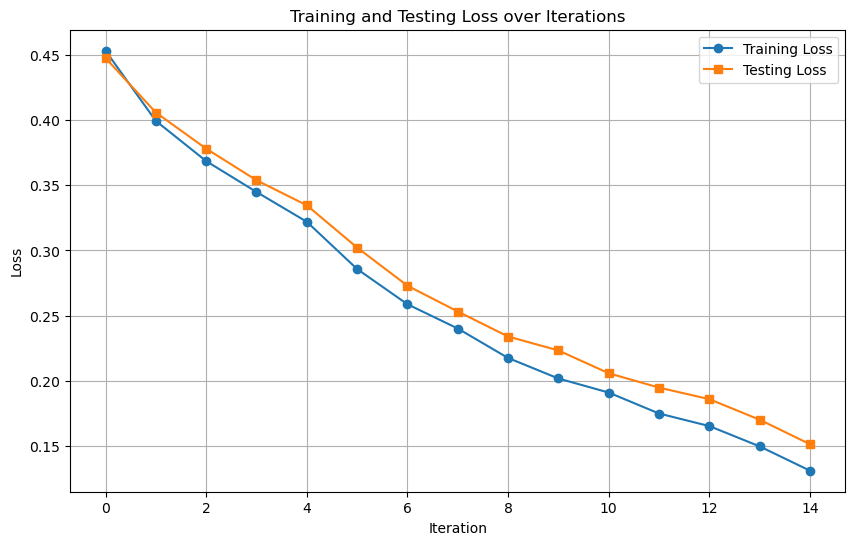

In [105]:
iterations = list(range(num_of_iter))

plt.figure(figsize=(10, 6))
plt.plot(iterations, a, label='Training Loss', marker='o')
plt.plot(iterations, c, label='Testing Loss', marker='s')
plt.title('Training and Testing Loss over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

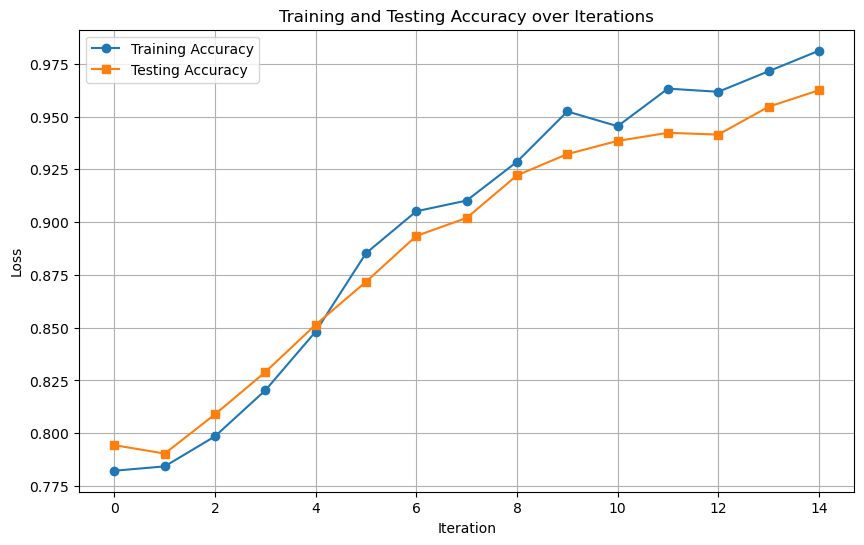

In [106]:
plt.figure(figsize=(10, 6))
plt.plot(iterations, b, label='Training Accuracy', marker='o')
plt.plot(iterations, d, label='Testing Accuracy', marker='s')
plt.title('Training and Testing Accuracy over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

**Testing Luke's data**

In [111]:
test_data = pd.read_csv('Luke/export_preds.csv')

In [125]:
account_list = test_data['account_id'].unique()

In [142]:
extracted_test_data = f_data[f_data['account_id'].isin(account_list)]

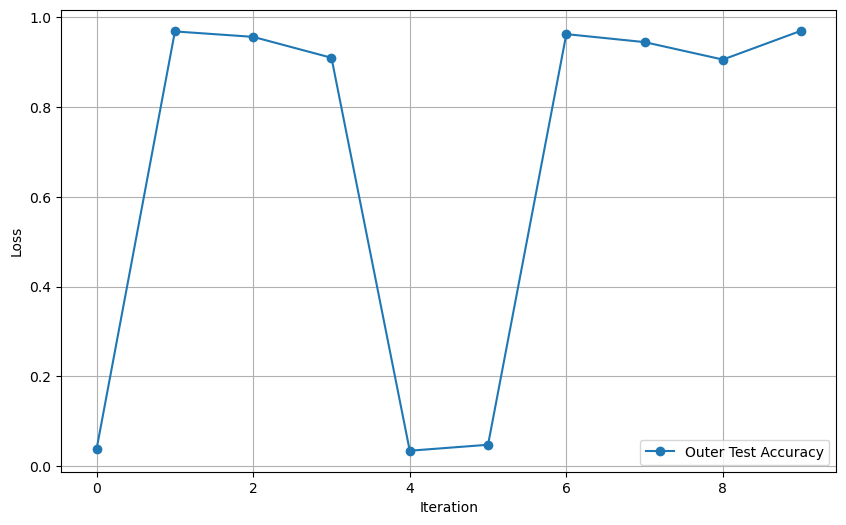

In [143]:
test_acc_list = []
iterations = list(range(10))

for i in range(len(iterations)):
    new_ed_id_lists = preprocessing(3000, extracted_test_data)
    new_train_loader, new_test_loader = data_loader(new_ed_id_lists, split = 0.2)
    test_loss, test_acc = evaluate(new_train_loader, rnn, lossfun, device)
    test_acc_list.append(test_acc)

plt.figure(figsize=(10, 6))
plt.plot(iterations, test_acc_list, label='Outer Test Accuracy', marker='o')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()